# Setup

In [1]:
!pip install mplsoccer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mplsoccer import Pitch, Sbopen, VerticalPitch

parser = Sbopen()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 337.4 kB/s eta 0:00:00


In [2]:
df, related, freeze, tactics = parser.event(3795506)
passes = df.loc[df['type_name'] == 'Pass'].loc[df['sub_type_name'] != 'Throw-in'].set_index('id')

# Italy's passes analysis

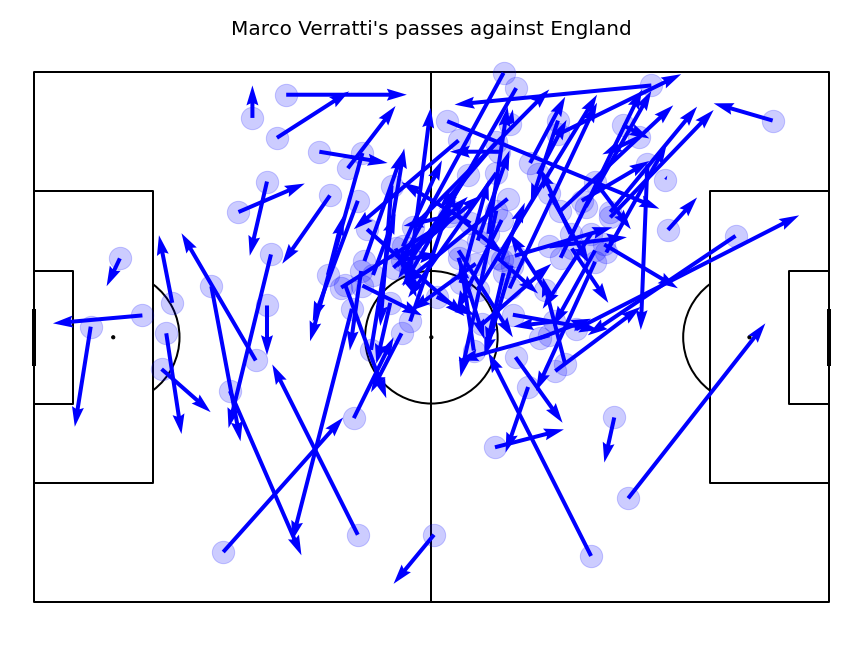

In [3]:
mask_bronze = (df.type_name == 'Pass') & (df.player_name == "Marco Verratti")
df_pass = df.loc[mask_bronze, ['x', 'y', 'end_x', 'end_y']]

pitch = Pitch(line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pitch.arrows(df_pass.x, df_pass.y,
            df_pass.end_x, df_pass.end_y, color = "blue", ax=ax['pitch'])
pitch.scatter(df_pass.x, df_pass.y, alpha = 0.2, s = 500, color = "blue", ax=ax['pitch'])
fig.suptitle("Marco Verratti's passes against England", fontsize = 20)
plt.show()

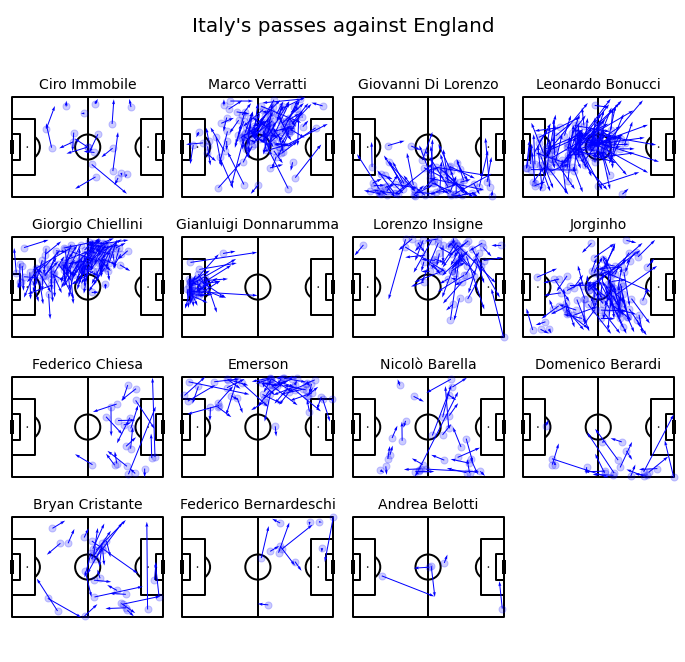

In [4]:
#prepare the dataframe of passes by England that were no-throw ins
df['player_name'] = df['player_name'].apply(lambda x: x.replace('Jorge Luiz Frello Filho', 'Jorginho') if x == 'Jorge Luiz Frello Filho' else x)
df['player_name'] = df['player_name'].apply(lambda x: x.replace('Emerson Palmieri dos Santos', 'Emerson') if x == 'Emerson Palmieri dos Santos' else x)
mask_italy = (df.type_name == 'Pass') & (df.team_name == "Italy") & (df.sub_type_name != "Throw-in")
df_passes = df.loc[mask_italy, ['x', 'y', 'end_x', 'end_y', 'player_name']]
#get the list of all players who made a pass
names = df_passes['player_name'].unique()

#draw 4x4 pitches
pitch = Pitch(line_color='black', pad_top=20)
fig, axs = pitch.grid(ncols = 4, nrows = 4, grid_height=0.85, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0.04, endnote_space=0.01)

#for each player
for name, ax in zip(names, axs['pitch'].flat[:len(names)]):
    #put player name over the plot
    ax.text(60, -10, name,
            ha='center', va='center', fontsize=14)
    #take only passes by this player
    player_df = df_passes.loc[df_passes["player_name"] == name]
    #scatter
    pitch.scatter(player_df.x, player_df.y, alpha = 0.2, s = 50, color = "blue", ax=ax)
    #plot arrow
    pitch.arrows(player_df.x, player_df.y,
            player_df.end_x, player_df.end_y, color = "blue", ax=ax, width=1)

#We have more than enough pitches - remove them
for ax in axs['pitch'][-1, 16 - len(names):]:
    ax.remove()

#Another way to set title using mplsoccer
axs['title'].text(0.5, 0.5, "Italy's passes against England", ha='center', va='center', fontsize=20)
plt.show()

In [5]:
#check for index of first sub
sub = df.loc[df["type_name"] == "Substitution"].loc[df["team_name"] == "Italy"].iloc[0]["index"]
#make df with successfull passes by England until the first substitution
mask_italy = (df.type_name == 'Pass') & (df.team_name == "Italy") & (df.index < sub) & (df.outcome_name.isnull()) & (df.sub_type_name != "Throw-in")
#taking necessary columns
df_pass = df.loc[mask_italy, ['x', 'y', 'end_x', 'end_y', "player_name", "pass_recipient_name"]]
#adjusting that only the surname of a player is presented.
df_pass["player_name"] = df_pass["player_name"].apply(lambda x: str(x).split()[-1])
df_pass["pass_recipient_name"] = df_pass["pass_recipient_name"].apply(lambda x: str(x).split()[-1])

In [6]:
scatter_df = pd.DataFrame()
for i, name in enumerate(df_pass["player_name"].unique()):
    passx = df_pass.loc[df_pass["player_name"] == name]["x"].to_numpy()
    recx = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_x"].to_numpy()
    passy = df_pass.loc[df_pass["player_name"] == name]["y"].to_numpy()
    recy = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_y"].to_numpy()
    scatter_df.at[i, "player_name"] = name
    #make sure that x and y location for each circle representing the player is the average of passes and receptions
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
    #calculate number of passes
    scatter_df.at[i, "no"] = df_pass.loc[df_pass["player_name"] == name].count().iloc[0]

#adjust the size of a circle so that the player who made more passes 
scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)

In [7]:
#counting passes between players
df_pass["pair_key"] = df_pass.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
lines_df = df_pass.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
#setting a treshold. You can try to investigate how it changes when you change it.
lines_df = lines_df[lines_df['pass_count']>2]

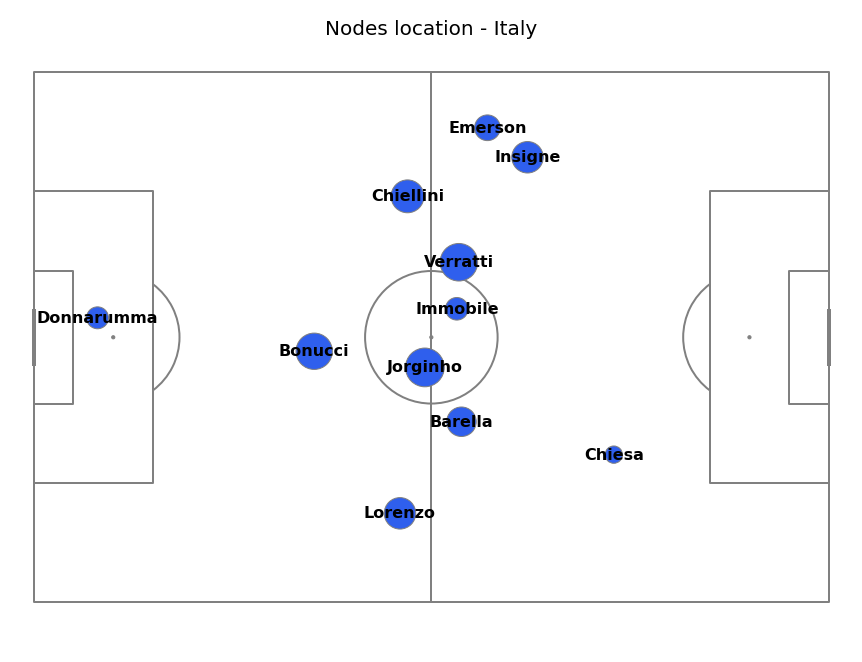

In [8]:
#Drawing pitch
pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#Scatter the location on the pitch
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='#2f5fed', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)
#annotating player name
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)

fig.suptitle("Nodes location - Italy", fontsize = 20)
plt.show()

In [9]:
lines_df['pair_key'] = lines_df['pair_key'].apply(lambda x: x.replace('Filho', 'Jorginho'))
lines_df['pair_key'] = lines_df['pair_key'].apply(lambda x: x.replace('Santos', 'Emerson'))

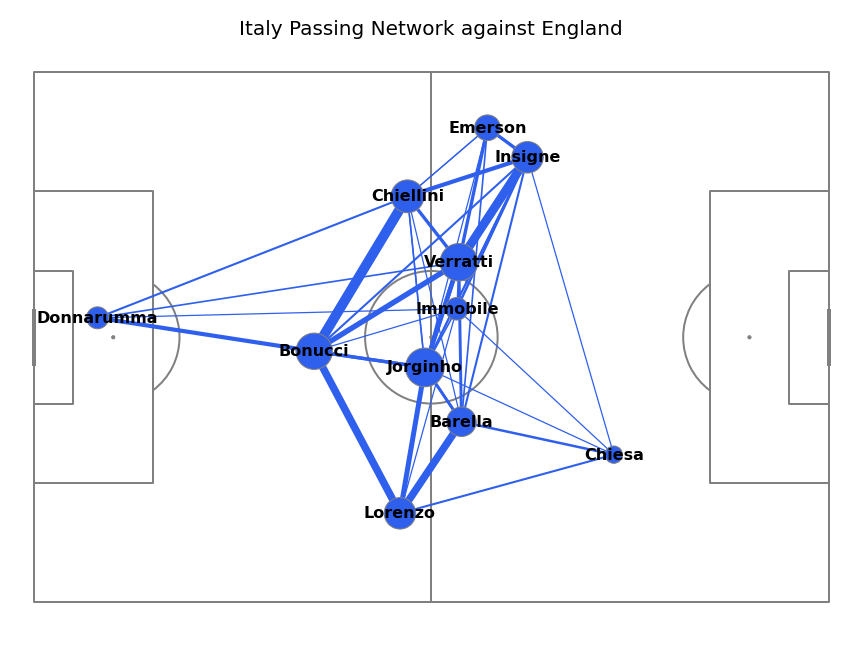

In [10]:
#plot once again pitch and vertices
pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='#2f5fed', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)
    
for i, row in lines_df.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        #take the average location of players to plot a line between them 
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
        num_passes = row["pass_count"]
        #adjust the line width so that the more passes, the wider the line
        line_width = (num_passes / lines_df['pass_count'].max() * 10)
        #plot lines on the pitch
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=1, lw=line_width, zorder=2, color="#2f5fed", ax = ax["pitch"])

fig.suptitle("Italy Passing Network against England", fontsize = 20)
plt.show()

In [11]:
#calculate number of successful passes by player
no_passes = df_pass.groupby(['player_name']).x.count().reset_index()
no_passes.rename({'x':'pass_count'}, axis='columns', inplace=True)
#find one who made most passes
max_no = no_passes["pass_count"].max()
#calculate the denominator - 10*the total sum of passes
denominator = 10*no_passes["pass_count"].sum()
#calculate the nominator
nominator = (max_no - no_passes["pass_count"]).sum()
#calculate the centralisation index
centralisation_index = nominator/denominator
print("Centralisation index is ", centralisation_index)

Centralisation index is  0.06320474777448071


# Danger passes

Danger passes are passes made 15 seconds before the shot.

In [12]:
#open the data
parser = Sbopen()
df_match = parser.match(competition_id=55, season_id=43)
#our team
team = "Italy"
#get list of games by our team, either home or away
match_ids = df_match.loc[(df_match["home_team_name"] == team) | (df_match["away_team_name"] == team)]["match_id"].tolist()
#calculate number of games
no_games = len(match_ids)

In [13]:
#declare an empty dataframe
danger_passes = pd.DataFrame()
for idx in match_ids:
    #open the event data from this game
    df = parser.event(idx)[0]
    for period in [1, 2]:
        #keep only accurate passes by England that were not set pieces in this period
        mask_pass = (df.team_name == team) & (df.type_name == "Pass") & (df.outcome_name.isnull()) & (df.period == period) & (df.sub_type_name.isnull())
        #keep only necessary columns
        passes = df.loc[mask_pass, ["x", "y", "end_x", "end_y", "minute", "second", "player_name"]]
        #keep only Shots by England in this period
        mask_shot = (df.team_name == team) & (df.type_name == "Shot") & (df.period == period)
        #keep only necessary columns
        shots = df.loc[mask_shot, ["minute", "second"]]
        #convert time to seconds
        shot_times = shots['minute']*60+shots['second']
        shot_window = 15
        #find starts of the window
        shot_start = shot_times - shot_window
        #condition to avoid negative shot starts
        shot_start = shot_start.apply(lambda i: i if i>0 else (period-1)*45)
        #convert to seconds
        pass_times = passes['minute']*60+passes['second']
        #check if pass is in any of the windows for this half
        pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())

        #keep only danger passes
        danger_passes_period = passes.loc[pass_to_shot]
        #concatenate dataframe with a previous one to keep danger passes from the whole tournament
        danger_passes = pd.concat([danger_passes, danger_passes_period])

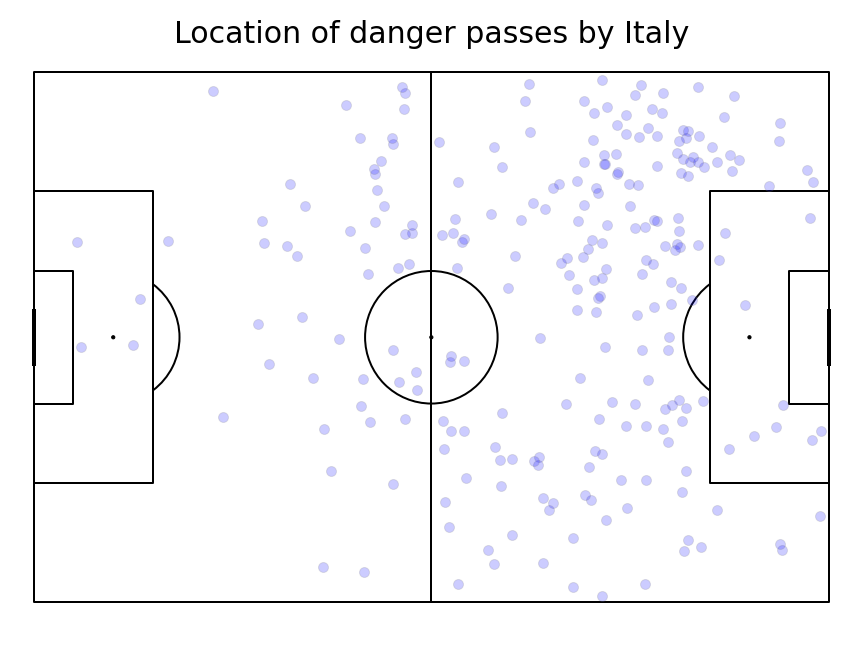

In [14]:
#plot pitch
pitch = Pitch(line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#scatter the location on the pitch
pitch.scatter(danger_passes.x, danger_passes.y, s=100, color='blue', edgecolors='grey', linewidth=1, alpha=0.2, ax=ax["pitch"])
#uncomment it to plot arrows
#pitch.arrows(danger_passes.x, danger_passes.y, danger_passes.end_x, danger_passes.end_y, color = "blue", ax=ax['pitch'])
#add title
fig.suptitle('Location of danger passes by ' + team, fontsize = 30)
plt.show()

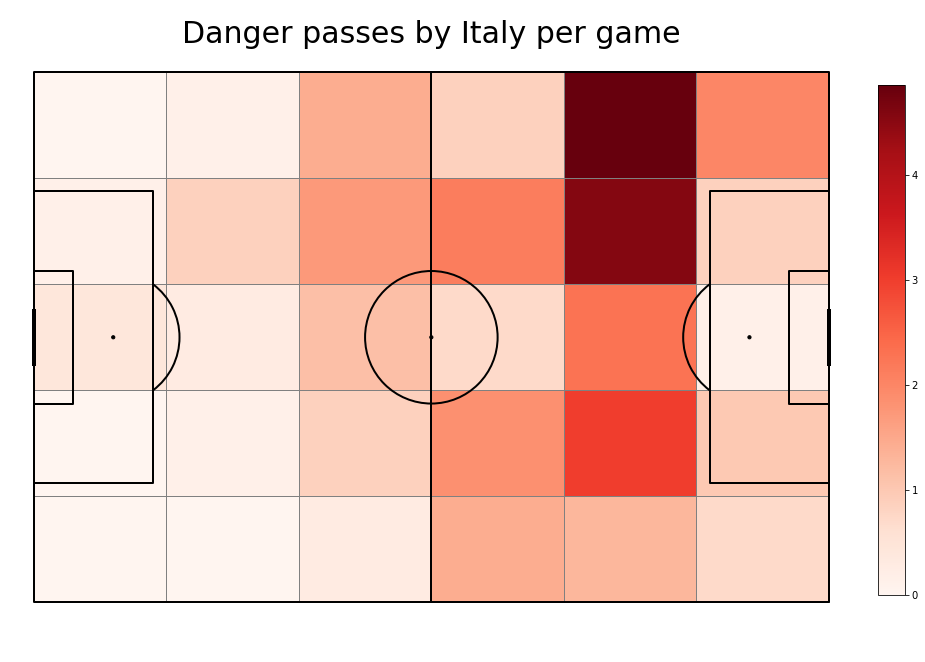

In [15]:
#plot vertical pitch
pitch = Pitch(line_zorder=2, line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#get the 2D histogram
bin_statistic = pitch.bin_statistic(danger_passes.x, danger_passes.y, statistic='count', bins=(6, 5), normalize=False)
#normalize by number of games
bin_statistic["statistic"] = bin_statistic["statistic"]/no_games
#make a heatmap
pcm  = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Danger passes by ' + team + " per game", fontsize = 30)
plt.show()

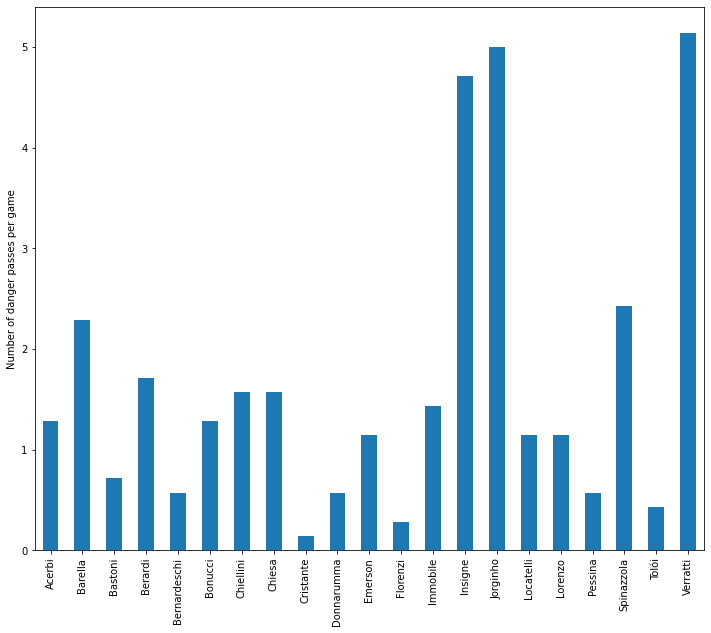

In [16]:
#keep only surnames
danger_passes["player_name"] = danger_passes["player_name"].apply(lambda x: str(x).split()[-1])
danger_passes['player_name'] = danger_passes['player_name'].apply(lambda x: x.replace('Filho', 'Jorginho') if x == 'Filho' else x)
danger_passes['player_name'] = danger_passes['player_name'].apply(lambda x: x.replace('Santos', 'Emerson') if x == 'Santos' else x)
#count passes by player and normalize them
pass_count = danger_passes.groupby(["player_name"]).x.count()/no_games

#make a histogram
plt.figure(figsize=(12,10))
ax = pass_count.plot.bar(pass_count)
#make legend
ax.set_xlabel("")
ax.set_ylabel("Number of danger passes per game")
plt.show()